# Sentiment Analysis IKN Article News




In [ ]:
# Install required packages
!pip install pandas emoji langdetect scikit-learn regex matplotlib seaborn wordcloud -q

import pandas as pd
import re
import emoji
import string
import logging
from langdetect import detect, LangDetectException
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from google.colab import files
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 12.7 MB/s eta 0:00:00


In [ ]:
# Inisialisasi logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [ ]:
# Unggah dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]
ikn_news_df = pd.read_csv(filename)
logger.info(f"Dataset {filename} dimuat dengan {len(ikn_news_df)} baris.")

Saving ikn_news_content_cleaned.csv to ikn_news_content_cleaned.csv


In [ ]:
# Validasi kolom awal
required_columns = ['judul', 'content', 'tanggal']
if not all(col in ikn_news_df.columns for col in required_columns):
    missing_cols = [col for col in required_columns if col not in ikn_news_df.columns]
    logger.error(f"Kolom yang hilang: {missing_cols}")
    raise ValueError(f"DataFrame harus memiliki kolom: {required_columns}")

In [ ]:
# Konfigurasi awal
initial_count = len(ikn_news_df)
important_acronyms = ['IKN', 'PSN', 'Bappenas', 'Kaltim']
ikn_keywords = ['IKN', 'Nusantara', 'pembangunan', 'ibu kota', 'Kaltim', 'Kalimantan', 'infrastruktur', 'investasi', 'anggaran', 'proyek']
normalization_dict = {
    'ga': 'tidak', 'nggak': 'tidak', 'kagak': 'tidak',
    'proyek': 'proyek', 'nuklir': 'nuklir',
    'ibu kota nusantara': 'IKN', 'kalimantan timur': 'Kaltim',
    'proyek strategis nasional': 'PSN', 'infrastruktur': 'infrastruktur',
    'investasi': 'investasi', 'anggaran': 'anggaran', 'pemerintahan': 'pemerintahan'
}
patterns_to_remove = [
    r'©\s*copyright\s*\d{4}.*?(?:all right reserved)?',
    r'beranda\s*»?', r'scroll to continue.*|baca berita.*klik disini',
    r'suara[kaltim|com]\.id\s*-', r'editor\s*:\s*[a-zA-Z\s]+',
    r'baca juga\s*:.*', r'readid\s*–', r'jakarta\s*,\s*cnbc\s*indonesia\s*-'
]
texts_to_remove = [
    "beranda", "© copyright 2024", "scroll to continue with cleaned_content",
    "beranda »", "© 2024 all right reserved", "readid –", "© 2023 penerbit berita infopublik",
    "© all right reserved by smg", "© copyright 2020 pemerintah kota tangerang",
    "©2024 promedia teknologi", "scan this qr or download app from jakarta inewsid",
    "copyright", "all right reserved", "copyright©2020", "no more post available no more page to load view more",
    "no more page to load view more", "type above and press enter to search press esc to cancel",
    "©", "»", "all right reserve", "scan this qr or download app from: idxchannel",
    "✨ Minal Aidin Walfaidzin, Mohon Maaf Lahir & Bathin ✨ Minal Aidin Walfaidzin, Mohon Maaf Lahir & Bathin Waktu.news |",
    "© Copyright 2025 Berita.News · Theme by HWD BERITA.NEWS,Kaltim", "© Copyright 2025", "Jakarta, CNBC Indonesia - ",
    "Scroll ke bawah untuk membaca berita Baca berita dengan sedikit , klik disini", "SuaraKaltim.id - ", "Suara.com - "
]

In [ ]:
# Fungsi preprocessing terintegrasi
def preprocess_text(text):
    try:
        # Standarisasi akronim
        for acronym in important_acronyms:
            text = re.sub(rf'(?i)\b{acronym}\b', acronym, str(text))

        # Hapus emoji dan karakter khusus
        text = emoji.replace_emoji(text, replace='')
        text = re.sub(r'[^\w\s.,!?éê]', '', text)

        # Normalisasi teks
        for slang, formal in normalization_dict.items():
            text = re.sub(rf'\b{slang}\b', formal, text, flags=re.IGNORECASE)
        text = re.sub(r',(?!\s)', ', ', text)
        text = text.replace('\\t', ' ').replace('\\n', ' ').replace('\\u', ' ').replace('\\', '')
        text = re.sub(r'(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?|(bit\.ly|tinyurl\.com|t\.co)\/[^\s\r\n]*', '', text)
        text = re.sub(r'\b\d{1,3}\b(?!\s*(?:miliar|triliun|hektar|tahun))', '', text)
        text = text.translate(str.maketrans('', '', string.punctuation.replace(',', '').replace('.', '')))
        text = re.sub(r'\s+', ' ', text).strip()

        # Hapus teks tidak relevan
        for pattern in patterns_to_remove:
            text = re.sub(pattern, '', text)
        for text_to_remove in texts_to_remove:
            text = text.replace(text_to_remove, '')

        # Lowercasing dengan pengecualian
        for acronym in important_acronyms:
            text = re.sub(rf'\b{acronym}\b', f'__{acronym}__', text, flags=re.IGNORECASE)
        text = text.lower()
        for acronym in important_acronyms:
            text = text.replace(f'__{acronym}__', acronym)

        return text
    except Exception as e:
        logger.error(f"Error in preprocess_text: {e}")
        return text

In [ ]:
# Fungsi deteksi bahasa dan relevansi
def is_valid_text(text):
    try:
        # Deteksi bahasa
        is_id = detect(text) == 'id' or any(keyword.lower() in text.lower() for keyword in ikn_keywords)
        # Cek relevansi (minimal 2 kata kunci)
        keyword_count = sum(1 for keyword in ikn_keywords if keyword.lower() in text.lower())
        return is_id and keyword_count >= 2
    except LangDetectException:
        logger.warning(f"Language detection failed for text: {text[:50]}...")
        return any(keyword.lower() in text.lower() for keyword in ikn_keywords) and sum(1 for keyword in ikn_keywords if keyword.lower() in text.lower()) >= 2
    except Exception as e:
        logger.error(f"Error in is_valid_text: {e}")
        return False

In [ ]:
# Fungsi hapus duplikasi berdasarkan konten
def remove_duplicates(df):
    try:
        vectorizer = TfidfVectorizer(max_features=5000)
        tfidf_matrix = vectorizer.fit_transform(df['cleaned_content'].fillna(''))
        cosine_sim = cosine_similarity(tfidf_matrix)
        indices_to_remove = set()
        for i in range(len(cosine_sim)):
            for j in range(i + 1, len(cosine_sim)):
                if cosine_sim[i][j] > 0.9:
                    indices_to_remove.add(j)
        return df.drop(index=indices_to_remove).reset_index(drop=True)
    except Exception as e:
        logger.error(f"Error in remove_duplicates: {e}")
        return df

In [ ]:
# Proses preprocessing utama
logger.info("Memulai preprocessing sebelum augmentasi...")
ikn_news_df['tanggal'] = pd.to_datetime(ikn_news_df['tanggal'], errors='coerce')
ikn_news_df = ikn_news_df.dropna(subset=['content'])  # Hapus baris dengan konten kosong

# Terapkan preprocessing
logger.info("Menerapkan preprocessing pada teks...")
ikn_news_df['cleaned_content'] = ikn_news_df['content'].apply(preprocess_text)
ikn_news_df['judul'] = ikn_news_df['judul'].apply(preprocess_text)

# Hapus duplikasi
logger.info("Menghapus duplikasi berdasarkan konten...")
ikn_news_df = remove_duplicates(ikn_news_df)
logger.info(f"Jumlah data setelah menghapus duplikasi: {len(ikn_news_df)}")

# Filter teks valid
logger.info("Memfilter teks berdasarkan bahasa dan relevansi...")
ikn_news_df = ikn_news_df[ikn_news_df['cleaned_content'].apply(is_valid_text)]
logger.info(f"Jumlah data setelah filter bahasa dan relevansi: {len(ikn_news_df)}")

# Analisis tambahan
logger.info("Melakukan analisis tambahan...")
ikn_news_df['tahun'] = ikn_news_df['tanggal'].dt.year
valid_dates = ikn_news_df.dropna(subset=['tanggal'])
if not valid_dates.empty:
    min_date = valid_dates['tanggal'].min()
    max_date = valid_dates['tanggal'].max()
    logger.info(f"Rentang tanggal berita: {min_date.strftime('%d-%m-%Y')} hingga {max_date.strftime('%d-%m-%Y')}")
else:
    logger.warning("Tidak ada data dengan tanggal valid.")

berita_per_tahun = ikn_news_df['tahun'].value_counts().sort_index()
logger.info("Distribusi berita per tahun:")
logger.info(berita_per_tahun.to_string())

<ipython-input-9-2446602312>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ikn_news_df['tahun'] = ikn_news_df['tanggal'].dt.year


<ipython-input-10-865802400>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=berita_per_tahun.index, y=berita_per_tahun.values, palette='viridis')


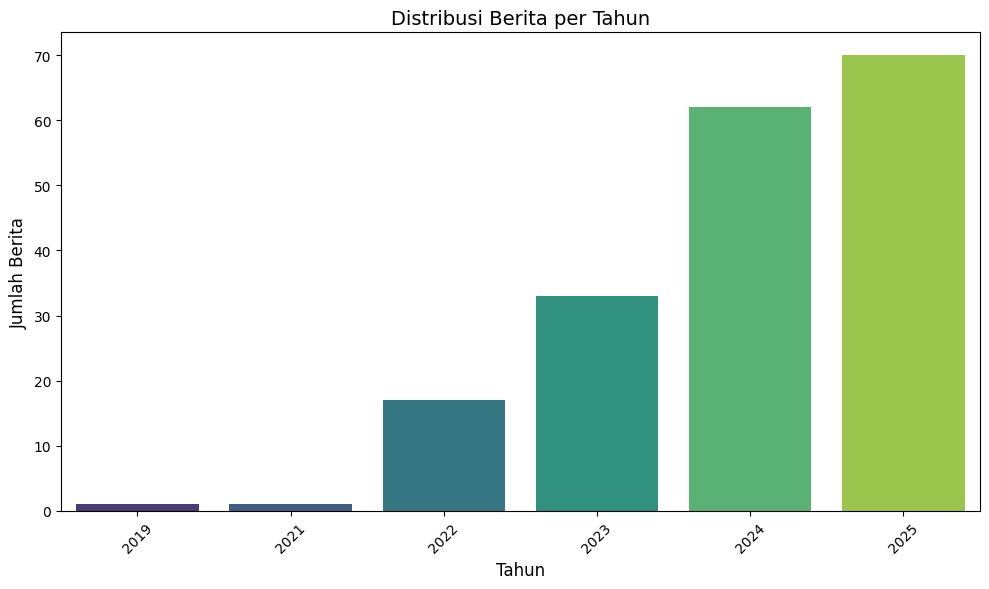

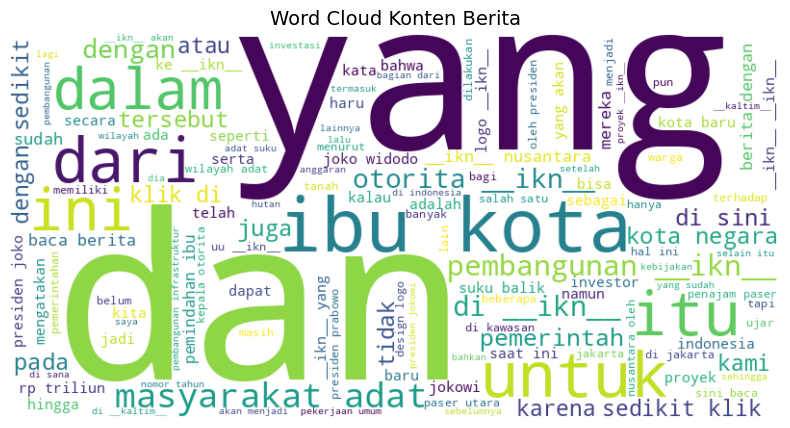

In [ ]:
# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=berita_per_tahun.index, y=berita_per_tahun.values, palette='viridis')
plt.title('Distribusi Berita per Tahun', fontsize=14)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Berita', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('berita_per_tahun.png')
plt.show()

# Word Cloud
wordcloud_text = ' '.join(ikn_news_df['cleaned_content'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS, min_font_size=10).generate(wordcloud_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Konten Berita', fontsize=14)
plt.savefig('wordcloud_preprocessed.png')
plt.show()

# Hitung kemunculan IKN
jumlah_IKN_content = ikn_news_df['cleaned_content'].str.contains(r'\bIKN\b', case=False).sum()
jumlah_IKN_judul = ikn_news_df['judul'].str.contains(r'\bIKN\b', case=False).sum()
logger.info(f"Jumlah kemunculan 'IKN' di kolom 'content': {jumlah_IKN_content}")
logger.info(f"Jumlah kemunculan 'IKN' di kolom 'judul': {jumlah_IKN_judul}")

# Simpan hasil
ikn_news_df.to_csv('ikn_news_preprocessed_before_augmentation.csv', index=False)
ikn_news_df.to_excel('ikn_news_preprocessed_before_augmentation.xlsx', index=False)
logger.info(f"Data disimpan ke ikn_news_preprocessed_before_augmentation.csv dan .xlsx")
logger.info(f"Jumlah data akhir: {len(ikn_news_df)} (dari awal {initial_count})")

# Validasi sampel
logger.info("Sampel 5 baris pertama setelah preprocessing:")
logger.info(ikn_news_df[['judul', 'cleaned_content', 'tanggal']].head().to_string())